In [1]:
%load_ext autoreload
%autoreload 2

import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\troy\\Documents\\Code\\Libraries', 'C:\\Users\\troy\\Documents\\Excel Sheets', 'C:/Users/troy/Documents/Code/Libraries'])
from datetime import date, datetime
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import autoreload

import dash_bootstrap_components as dbc
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output

from FinAPI.NumerixWrapper import Base, USDOIS_MeetingDate, MeetingDates, CompoundIndexSwap, AverageIndexSwap

Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)] on win32


ImportError: No licenses for product [NxSDKCpp] are installed.

## Create Meeting Date Curve

In [2]:
objMeetingDate = USDOIS_MeetingDate(base_object=Base)
objMeetingDate.create_curve()

[2021-12-22 20:39:28,323] DEBUG [NumerixCurve] [YieldCurves.py] [create_curve][866] [PID:15800 TID:22584] Fetching Data from Bloomberg
[2021-12-22 20:39:29,907] DEBUG [NumerixCurve] [YieldCurves.py] [create_curve][868] [PID:15800 TID:22584] Creating Instruments and Collections ... 
[2021-12-22 20:39:29,912] DEBUG [NumerixCurve] [YieldCurves.py] [create_curve][872] [PID:15800 TID:22584] Bootstrapping Curve ... 


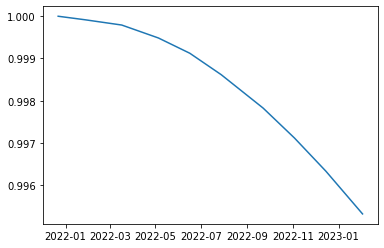

In [3]:
objMeetingDate.plot_discount_factors()

## Extract Information from the curve

#### Daily Index to show jumps of the index rates

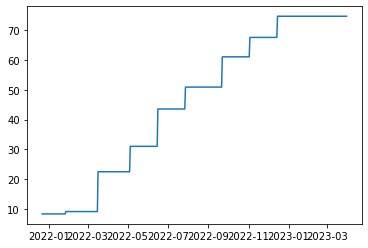

In [4]:
index_rates = objMeetingDate.index_rates()
plt.plot(index_rates)

In [57]:
# OIS Curve Meeting date
fed_pricing = objMeetingDate.move_pricing_table()
fed_pricing

,OIS Rate,avg_rate,slope,cumm,marginal_perc,cumm_perc
2021-12-22,8.364,8.364,0.000,0.000,0.00000,0.00000
2022-01-26,9.142,9.158,0.794,0.794,0.03176,0.03176
2022-03-16,22.230,22.499,13.341,14.135,0.53364,0.56540
2022-05-04,30.820,31.017,8.518,22.653,0.34072,0.90612
2022-06-15,43.251,43.538,12.521,35.174,0.50084,1.40696
2022-07-27,50.771,50.883,7.345,42.519,0.29380,1.70076
2022-09-21,60.800,61.021,10.138,52.657,0.40552,2.10628
2022-11-02,67.404,67.533,6.512,59.169,0.26048,2.36676
2022-12-14,74.521,74.629,7.096,66.265,0.28384,2.65060


2021

## Scratch

In [117]:
from tia.bbg import LocalTerminal

data_date = date(2021, 12, 23)
data_date = data_date if data_date is not None else Base.today_tz("USNY")
fut_tickers = ['FF2 Comdty', 'FF3 Comdty', 'FF4 Comdty', 'FF5 Comdty', 'FF6 Comdty', 'FF7 Comdty',
                   'FF8 Comdty', 'FF9 Comdty', 'FF10 Comdty', 'FF11 Comdty', 'FF12 Comdty', 'FF13 Comdty']
live = True if data_date == Base.today_tz("USNY") else False

if live:
    resp = LocalTerminal.get_reference_data(fut_tickers, ['PX_MID', 'PX_LAST'])
    df_fut = resp.as_frame()
    df_fut['MID_OR_LAST'] = (1 - np.isnan(df_fut.PX_MID)) * df_fut.PX_MID.fillna(0) + np.isnan(df_fut.PX_MID) * df_fut.PX_LAST
else:
    resp = LocalTerminal.get_historical(fut_tickers, ['PX_MID', 'PX_LAST'], start=data_date, end=data_date)
    df_fut = resp.as_frame()
    df_fut = df_fut.iloc[0].reset_index()
    df_fut.columns = ['FUT', 'FIELD', 'VAL']
    df_fut_pivot = df_fut.pivot(index='FUT', columns='FIELD', values='VAL')
    df_fut_pivot['MID_OR_LAST'] = (1 - np.isnan(df_fut_pivot.PX_MID)) * df_fut_pivot.PX_MID.fillna(0) + np.isnan(df_fut_pivot.PX_MID) * df_fut_pivot.PX_LAST
    df_fut = df_fut_pivot
 
df_fut

FIELD,PX_LAST,PX_MID,MID_OR_LAST
FUT,,,
FF10 Comdty,99.445,NaN,99.445
FF11 Comdty,99.370,99.370,99.370
FF12 Comdty,99.310,99.310,99.310
FF13 Comdty,99.245,99.280,99.280
FF2 Comdty,99.920,99.918,99.918
FF3 Comdty,99.905,99.908,99.908
FF4 Comdty,99.835,99.838,99.838
FF5 Comdty,99.760,99.757,99.757
FF6 Comdty,99.690,99.688,99.688


## Get History

In [86]:
# OIS Convention

Base.generator_helper.USD_OIS_SHORT
Base.generator_helper.USD_OIS_DEFAULT

# Fed Fund Future
Base.generator_helper.USD_FF_FUT

# FEDL01 Rate Convention
Base.generator_helper.USD_FEDFUNDS_RATECONVENTION

# Retrieve the roll and calendar for CASH
cash_conv_dict = Base.view_convention_defaults(Base.generator_helper.USD_OIS_CASH).set_index('NAME').to_dict()['VALUE']
cash_conv_dict['Payconv'], cash_conv_dict['Paycal']


('F', 'FRB')

## Get Option related Data

## FED FUND FUTURES

In [142]:
from FinAPI.NumerixWrapper import AverageOvernightFutures

In [151]:
data_dt = date.today()
tickers = ["FF%s Comdty" % i for i in range(1, 26)]
cur_static_field = ['FUT_CUR_GEN_TICKER', 'INT_RATE_FUT_START_DT', 'INT_RATE_FUT_END_DT']
snap_fields = ['PX_MID', 'PX_LAST', 'PX_YEST_CLOSE']
resp = LocalTerminal.get_reference_data(tickers, cur_static_field)
df = resp.as_frame().sort_values(by='INT_RATE_FUT_START_DT')
future_code = ["%s%s" % (v[2], d.strftime('%y')) for v, d in zip(df['FUT_CUR_GEN_TICKER'], df['INT_RATE_FUT_START_DT'])]
df = df.assign(Code=future_code)

resp = LocalTerminal.get_reference_data(tickers, snap_fields)
price_df = resp.as_frame()

snap_df = df.join(price_df)
table_df = snap_df[['Code', "PX_MID", "PX_LAST", "PX_YEST_CLOSE"]]

# Create FF Future Objects
fut_objs = dict()
for i in table_df.index:
    fut_data = table_df.loc[i,:].to_dict()
    code = fut_data['Code']
    px_mid = fut_data['PX_MID']
    px_last = fut_data['PX_LAST']
    px_close = fut_data['PX_YEST_CLOSE']
    px_mid_or_last = px_last if np.isnan(px_mid) else px_mid
    objFuture = AverageOvernightFutures(Base, "USD", "FF", "CBOT", code, quotedprice=px_mid_or_last, generator="USD FF FUT")
    fut_objs[code] = objFuture

future_ids = [v.id for k,v in fut_objs.items()]
data = pro.ApplicationData()
data.add_values('ID', future_ids)
data_id = Base.get_unique_id('USD_ON_FUT_DATA_')
fut_coll = Base._app_data(data_id, data)

# Meeting Dates 
scheduled_meetings = [date(2022, 1, 26), date(2022, 3, 16),
                          date(2022, 5, 4), date(2022, 6, 15),
                          date(2022, 7, 27), date(2022, 9, 21),
                          date(2022, 11, 2), date(2022, 12, 14),
                          date(2023, 2, 1)
                          ]
tentative_meetings = [date(2023, 3, 15), date(2023, 5, 3),
                        date(2023, 6, 14), date(2023, 7, 26),
                        date(2023, 9, 20), date(2023, 11, 1),
                        date(2023, 12, 13), date(2024, 1, 31),
                        date(2024, 3, 13), date(2024, 5, 1),
                        date(2024, 6, 12), date(2024, 7, 31),
                        date(2024, 9, 25), date(2024, 11, 6),
                        date(2024, 12, 18)]

meeting_dates = scheduled_meetings + tentative_meetings

# Find the last future which covers all the meeting dates
snap_df[snap_df['INT_RATE_FUT_END_DT']<max(meeting_dates)]


NameError: name 'pro' is not defined